# Backtest and Analysis Notebook

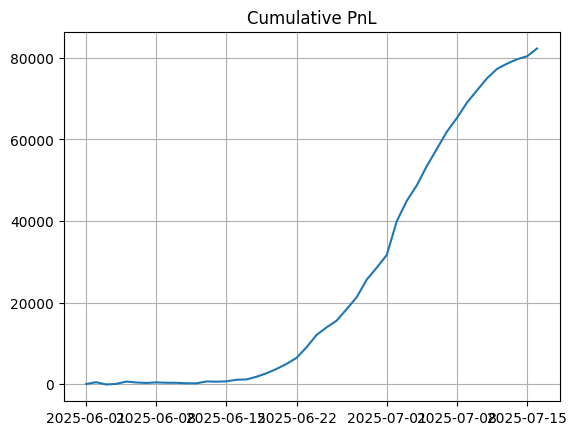

In [4]:
import sys, os
import pandas as pd


# 1) Point to the repo root:
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# 2) Add both the repo root AND the src folder:
sys.path.insert(0, repo_root)
sys.path.insert(0, os.path.join(repo_root, "src"))

from data_loader   import fetch_options
from strategy      import generate_signals
from analytics     import compute_pnl

# 2) Build a multi‐date dataset
start = datetime(2025, 6, 1)
end   = datetime(2025, 7, 17)
all_dfs = []

current = start
while current <= end:
    dt = current.date()
    try:
        df_day = fetch_options("SPY")
        df_day["date"] = dt           # overwrite the snapshot’s date
        all_dfs.append(df_day)
    except Exception as e:
        print(f"Failed on {dt}: {e}")
    current += timedelta(days=1)

full_df = pd.concat(all_dfs, ignore_index=True)

# 3) Save
data_path = os.path.join(repo_root, "data", "options_data.csv")
full_df.to_csv(data_path, index=False)

# 4) Reload & backtest
df = pd.read_csv(data_path, parse_dates=["date","expiry"])
df = generate_signals(df)
pnl_df = compute_pnl(df)

# 5) Plot
import matplotlib.pyplot as plt
plt.plot(pnl_df["date"], pnl_df["cumulative_pnl"])
plt.title("Cumulative PnL")
plt.grid(True)
plt.show()
